In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn import metrics
from struct import unpack
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def load_mnist(image_file_name, label_file_name):
    images = open(image_file_name, 'rb')
    labels = open(label_file_name, 'rb')
    
    images.read(4) # I guess this is to dump some format specific non-data
    number_of_images = images.read(4) # I guess these bits actually have described how many images there are?
    number_of_images = unpack('>I', number_of_images)[0] # Okay this might be the decoding part.
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]
    labels.read(4) # this is once again just dumping 4 bytes for some reason
    N = labels.read(4)
    N = unpack('>I', N)[0] # Based on above, assuming this is the number of labels?
    
    total_number_pixels = rows * cols
    x = np.zeros((N, total_number_pixels), dtype=np.uint8) # N should be the same as number_of_images right?
    y = np.zeros(N, dtype=np.uint8) # Same, initialize with 0s
    for i in range(N):
        for j in range(total_number_pixels):
            tmp_pixel = images.read(1) # Read a pixel
            tmp_pixel = unpack('>B', tmp_pixel)[0] # Unpack with some other decoder?
            x[i][j] = tmp_pixel # Put pixel value into bitmap (flated into 1D per image)
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0] # Why are we using this decoder instead of >I again?
        
    images.close()
    labels.close()
    return (x,y)

In [13]:
train_img, train_lbl = load_mnist('../MNIST_dataset/train-images.idx3-ubyte', '../MNIST_dataset/train-labels.idx1-ubyte')
test_img, test_lbl = load_mnist('../MNIST_dataset/t10k-images.idx3-ubyte', '../MNIST_dataset/t10k-labels.idx1-ubyte')

In [4]:
## We're gong to do CV instead of a simple plite here
# num_train_img = train_img.shape[0]
# train_img, validate_img = train_img[:int(0.8*num_train_img)], train_img[int(0.8*num_train_img):]
# train_lbl, validate_lbl = train_lbl[:int(0.8*num_train_img)], train_lbl[int(0.8*num_train_img):]

In [14]:
train_img.shape

(60000, 784)

In [15]:
train_lbl.shape

(60000,)

In [7]:
# validate_img.shape

(12000, 784)

In [8]:
# validate_lbl.shape

(12000,)

In [9]:
rf_model = RandomForestClassifier()

In [10]:
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, verbose=2, n_jobs = -1)
rf_random.fit(train_img, train_lbl)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 117.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 565.9min


KeyboardInterrupt: 

#### This is just taking way too long, my laptop isn't able to handle this
* The original plan is to do a grid sample of 100 attempts and find a more optimized direction so we could countinue fine tunrin around it

In [21]:
rf_model = RandomForestClassifier(max_depth = 3, n_jobs=-1 ) # to limit run time, or maybe we should limit number of leaves?
rf_model.fit(train_img, train_lbl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Whoa this is super fast, I guess I can fine tun this.

In [22]:
num_train_img = train_img.shape[0]
train_img, validate_img = train_img[:int(0.8*num_train_img)], train_img[int(0.8*num_train_img):]
train_lbl, validate_lbl = train_lbl[:int(0.8*num_train_img)], train_lbl[int(0.8*num_train_img):]

In [26]:
train_accuracy = []
validate_accuracy = []
for nodes in [100,1000,10000,100000,1000000]:
    rf_model = RandomForestClassifier(max_leaf_nodes = nodes, n_jobs=-1 ) # limit number of leaves this time
    rf_model.fit(train_img, train_lbl)
    train_accuracy.append(rf_model.score(train_img,train_lbl))
    validate_accuracy.append(rf_model.score(validate_img, validate_lbl))

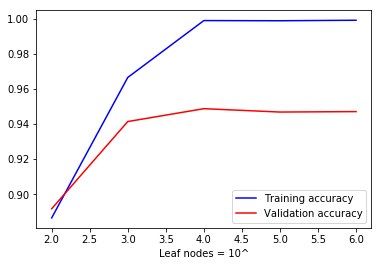

In [27]:
plt.plot(range(2,7), train_accuracy, 'b-', range(2,7), validate_accuracy, 'r-')
plt.legend(('Training accuracy', 'Validation accuracy'))
plt.xlabel('Leaf nodes = 10^')
plt.show()

In [28]:
# Seem like 10000 leaf nodes has achieved a reasonable result, after that it starts to overfit
train_img, train_lbl = np.concatenate((train_img, validate_img)), np.concatenate((train_lbl, validate_lbl))
rf_model = RandomForestClassifier(max_leaf_nodes = 10000, n_jobs=-1 )
rf_model.fit(train_img, train_lbl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=10000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
result = rf_model.predict(test_img)
# Creat onehot encoding
onehot = np.zeros((result.size, 10))
onehot[np.arange(result.size), result] = 1
np.savetxt('rf.csv', onehot, delimiter=',',fmt='%i')

In [31]:
# I want to see how well it did
print(rf_model.score(test_img, test_lbl))

0.9492
